In [162]:
# imports & matplotlib options

import pyocr.builders
import pyocr
import pandas as pd
import numpy as np
import ipywidgets as widgets
import cv2
import collections
import random
import pytesseract
from shutil import copy
from pathlib import Path
from datetime import datetime
from collections import OrderedDict
from autocorrect import spell
from fuzzywuzzy import fuzz, process
from ipywidgets import interact, IntProgress, Label, VBox
from IPython.display import display
from matplotlib import pyplot as plt
import img_qc.img_qc as img_qc
from skimage.measure import compare_ssim as ssim
from PIL import Image
%matplotlib inline

tools = pyocr.get_available_tools()
tool = tools[0]

plt.rc('figure', figsize=(30.0, 20.0))


print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-23 08:46:20 PM


In [2]:
# pre-built lists to iterate over
months = [
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october',
    'november',
    'december'
]

january_list = 

roi_box_list = ['text', 'left', 'top', 'width', 'height']

print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-23 05:16:47 PM


In [115]:
# test dictionary use
common_mistakes_dict = {'j': 't', 'd': 'j', 't': 'l'}
for key in common_mistakes_dict:
    print(key)
    print('\t' + common_mistakes_dict[key])

j
	t
d
	j
t
	l


In [122]:
# create a dictionary of possible month corrections
months_dict = {}
for month in months:
    correction_list = []
    for i in range(3):
        correction = month[i:]
        if len(correction) > 2:
            correction_list.append(month[i:])
    for i in range(1, 3):
        i = len(month) - i
        correction = month[:i]
        if len(correction) > 2:
            correction_list.append(month[:i])
    # print(correction_list)
    errors_dict = {'j': 't', 'd': 'j', 't': 'l'}
    for error in errors_dict:
        for correction in correction_list:
            if error in correction:
                # print(error, errors_dict[error])
                replaced = correction.replace(error, errors_dict[error])
                # print(replaced)
                correction_list.append(replaced)
        
    months_dict[month] = correction_list
# the first 2 letters can be missing
months_dict

{'january': ['january',
  'anuary',
  'nuary',
  'januar',
  'janua',
  'tanuary',
  'tanuar',
  'tanua',
  'lanuary',
  'lanuar',
  'lanua'],
 'february': ['february', 'ebruary', 'bruary', 'februar', 'februa'],
 'march': ['march', 'arch', 'rch', 'marc', 'mar'],
 'april': ['april', 'pril', 'ril', 'apri', 'apr'],
 'may': ['may'],
 'june': ['june', 'une', 'jun', 'tune', 'tun', 'lune', 'lun'],
 'july': ['july', 'uly', 'jul', 'tuly', 'tul', 'luly', 'lul'],
 'august': ['august',
  'ugust',
  'gust',
  'augus',
  'augu',
  'augusl',
  'ugusl',
  'gusl'],
 'september': ['september',
  'eptember',
  'ptember',
  'septembe',
  'septemb',
  'seplember',
  'eplember',
  'plember',
  'seplembe',
  'seplemb'],
 'october': ['october',
  'ctober',
  'tober',
  'octobe',
  'octob',
  'oclober',
  'clober',
  'lober',
  'oclobe',
  'oclob'],
 'november': ['november', 'ovember', 'vember', 'novembe', 'novemb'],
 'december': ['december',
  'ecember',
  'cember',
  'decembe',
  'decemb',
  'jecember',
  'j

In [3]:
# create page 1 paths list
data_dir_path = Path('data/')
page_1_paths_list = sorted(data_dir_path.glob('images/*.tif'))

# delete macOS '.' index files
regenerate_paths_list = False
for path in page_1_paths_list:
    if path.name.startswith('.'):
        path.unlink()
        regenerate_paths_list = True

if regenerate_paths_list:
    page_1_paths_list = sorted(data_dir_path.glob('images/*.tif'))

print(f'{len(page_1_paths_list)} images in page 1 paths list')


print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')

413 images in page 1 paths list

*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-23 05:16:47 PM


In [4]:
# data for creating sub-crops to find

# create OrderedDictionary for Title Crop data
title_data_ordered_dict = OrderedDict()
title_data_ordered_dict['Agricultural and home economics packet'] = OrderedDict(
    [('rgb_0', [3295, (250, 450, 1450, 1150)])])
title_data_ordered_dict['Agricultural news'] = OrderedDict(
    [('rgb_0', [3446, (1150, 50, 3200, 850)])])
title_data_ordered_dict['Farm news'] = OrderedDict(
    [('gray_0', [2364, (1400, 500, 2650, 875)])])
title_data_ordered_dict['Agricultural & home economics news'] = OrderedDict([
    ('rgb_0', [2750, (1100, 50, 3150, 900)]),
    ('rgb_1', [2951, (250, 500, 3050, 1100)])
])
title_data_ordered_dict['Tennessee farm and home news'] = OrderedDict([
    ('gray_0', [1670, (1400, 150, 3150, 300)]),
    ('gray_1', [964, (1400, 150, 3175, 290)]),
    ('gray_2', [2151, (1250, 150, 3025, 325)])
])
title_data_ordered_dict['Tennessee farm news'] = OrderedDict([
    ('gray_0', [5, (725, 525, 2100, 750)]),
    ('gray_1', [15, (550, 600, 1950, 750)]),
    ('gray_2', [456, (1000, 550, 2400, 675)]),
    ('gray_3', [254, (800, 500, 2200, 650)]),
    ('gray_4', [44, (850, 475, 2250, 600)])
])

print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-23 05:16:48 PM


In [5]:
# utility functions
def crop_image_for_processing(image, percentage=0.4, top_and_sides_padding=10):

    # get technical metadata
    height, width = image.shape[:2]

    # set (x, y) pairs
    x1, y1, x2, y2 = 0, 0, width, int(height * percentage)

    # add/subtract padding from the top/left/right
    x1 += top_and_sides_padding
    y1 += top_and_sides_padding
    x2 -= top_and_sides_padding
    # add image area to the bottom that was cropped from the top
    y2 += top_and_sides_padding

    # crop image
    image = image[y1:y2, x1:x2]

    return image


def get_np_crop_points(crop_box):
    x_points = []
    y_points = []
    # print(f'crop box: {crop_box}')

    # append all x/y points to their respective lists
    for i in range(len(crop_box)):
        if crop_box[i][0][0]:
            x = (crop_box[i][0][0])
            if x < 0:
                x = -x
            x_points.append(x)
        if crop_box[i][0][1]:
            y = crop_box[i][0][1]
            if y < 0:
                y = -y
            y_points.append(y)
    # print('x/y points')
    # print(x_points, y_points)

    # find extremes in crop box
    x1 = min(x_points)
    x2 = max(x_points)
    y1 = min(y_points)
    y2 = max(y_points)
    # print(f'x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}')

    return x1, y1, x2, y2


def if_rgb_convert_to_gray(np_image):
    if len(np_image.shape) > 2:
        np_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)

    return np_image


def if_bgr_convert_to_gray(np_image):
    if len(np_image.shape) > 2:
        np_image = cv2.cvtColor(np_image, cv2.COLOR_BGR2GRAY)

    return np_image


def resize(image, width=None, height=None, ratio=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        ratio = height / float(h)
        dim = (int(w * ratio), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        ratio = width / float(w)
        dim = (width, int(h * ratio))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized, ratio


def resize_ratio(image, ratio, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    dim = (int(w * ratio), int(h * ratio))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized


def quick_imshow(bgr_image):
    if len(bgr_image.shape) > 2:
        bgr_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        cmap = None
    else:
        cmap = 'gray'
    plt.imshow(bgr_image, cmap=cmap), plt.show()
    
    return


print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-23 05:16:49 PM


In [143]:
# ocr functions
def search(values, searchFor):
    for k in values:
        for v in values[k]:
            if searchFor in v:
                return k
    return None

def get_month(line_and_word_boxes, debug=None):
    # draw month box on page
    filter_chars = 'abcdefghijklmnopqrstuvwxyz1234567890 '
    finding_month = True
    for line in line_and_word_boxes:
        # print(line.content)
        
        # filter found characters for a-z, 0-9, and 'spaces'
        line_condensed = [x for x in line.content if x.lower() in filter_chars]
        
        # join everything together into a single string
        string = ''
        text = string.join(line_condensed)
        # print(text)
        
        # split text into words at spaces
        for word in text.split(' '):
            if len(word) > 2 and finding_month:
                fixed_word = spell(word)
                month = search(months_dict, fixed_word.lower())
                if month:
                    return word, month
                # if word.lower() in months and finding_month:
                #     month = word.lower()
                #     # print(line.position)
                #     for box in line.word_boxes:
                #         if box.content.lower() == month:
                #             found_month = month
                #             # print(box.content)
                #             # print(box.position)
                #             (x1, y1), (x2, y2) = box.position[:2]
                #             padding = 10
                #             x1 -= padding
                #             x2 += padding
                #             y1 -= padding
                #             y2 += padding
                #             drawing = cv2.rectangle(
                #                 image.copy(), (x1, y1), (x2, y2), (255, 255, 0), 3)
                #             drawing = cv2.cvtColor(drawing, cv2.COLOR_BGR2RGB)
                #             plt.imshow(drawing), plt.show()
                #             finding_month = False
    # quick_imshow(image)          
    return None


def get_month_crop(image, ocr_df):

    ocr_df.dropna(subset=['text'], inplace=True)

    box = False
    month_crop = []
    date_crop = []
    month_line = 0
    month_word = 0

    # assume the first month we find is correct
    month_found = False
    # print(ocr_df)

    for index, row in enumerate(ocr_df.itertuples()):
        # print(f'row: {row}')
        text = row.text
        # print(index, text)
        if not month_found:
            if isinstance(text, float):
                pass
            else:
                # print(text)
                test_text = spell(text)
                if test_text:
                    text = test_text
                # print(text)
                if text.lower() in months:
                    # print(ocr_df.iloc[index])
                    box = []
                    for edge in roi_box_list:
                        # print(box)
                        # print(ocr_df.iloc[index][edge])
                        box.append(ocr_df.iloc[index][edge])
                    month_found = True
                    par_num = ocr_df.iloc[index]['par_num']
                    line_num = ocr_df.iloc[index]['line_num']
                    word_num = ocr_df.iloc[index]['word_num']
    # print(month_line, month_word)
    date_dataframe = ocr_df.loc[(ocr_df['par_num'] == par_num) & (
        ocr_df['line_num'] == line_num) & (ocr_df['word_num'] >= word_num)]
    # print(date_dataframe)
    date_dataframe = date_dataframe[[
        'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'text']]
    # print(date_dataframe)

    if not month_found:  # add all text into a single string and find closest match to a month
        # TO DO!
        pass

    if box:
        # print(box)
        box = [int(x) if x != box[0] else x for x in box]
        text, x1, y1, box_width, box_height = box
        x2 = x1 + box_width
        y2 = y1 + box_height

        # print(box)
        image_to_crop = cv2.imread(str(image_path))
        width, height = image_to_crop.shape[:2]
        month_crop = image_to_crop[y1:y2, x1:x2]
        # quick_imshow(month_crop)

        # crop image and get date box based on finding the month
        # date_x1 = x1 - 30
        # date_x2 = x1 + 600
        # date_y1 = y1 - 30
        # date_y2 = y2 + 30
        # date_x1 = max(0, date_x1)
        # date_y1 = max(0, date_y1)
        # date_x2 = min(date_x2, width)
        # date_y2 = min(date_y2, height)

        # date_crop = image_to_crop[date_y1:date_y2, date_x1:date_x2]
        # quick_imshow(date_crop)

    # return cropped images
    return month_crop, date_dataframe

print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-23 08:33:13 PM


In [7]:
# sub-crop finding classes
class RootSIFT:
    def __init__(self, extractor):
        # initialize the SIFT feature extractor
        self.extractor = extractor

    def compute(self, image, keypoints, epsilon=1e-7):
        # compute SIFT descriptors
        (keypoints, descriptors) = self.extractor.detectAndCompute(image, None)

        # if there are are no keypoints or descriptors
        if len(keypoints) == 0:
            # return an empty tuple
            return ([], None)

        # apply the Hellinger kernel by first L1-normalizing and taking the
        # square root
        descriptors /= (descriptors.sum(axis=1, keepdims=True) + epsilon)
        descriptors = np.sqrt(descriptors)

        # return a tuple of the keypoints and descriptors
        return (keypoints, descriptors)


print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-23 05:16:50 PM


In [8]:
# image sub-crop finding functions


def create_crop_dictionary(data_dictionary, show_images=False):

    crop_dictionary = OrderedDict()
    # bgr_crop_dictionary = OrderedDict()
    # gray_crop_dictionary = OrderedDict()

    for title, data in data_dictionary.items():

        print(f'Processing {title} . . .')
        print(f'\t\tsub_title\tadminDB\t\tcrop_box (x1, y1, x2, y2)')
        # print(data)

        if title not in crop_dictionary:  # instantiate empty OrderedDict
            crop_dictionary[title] = OrderedDict()
            # print(crop_dictionary)

        for sub_title, (adminDB, crop_box) in data.items():
            print(f'\t\t{sub_title}\t\t{adminDB}\t\t{crop_box}')
            # get image color, image_path, and crop box from sub_data
            colorspace = sub_title.split('_')[0]

            # print(colorspace)
            adminDB_ending = f'{str(adminDB).zfill(6)}_0001.tif'
            # print(adminDB_ending)
            try:
                image_path = [
                    x for x in page_1_paths_list if x.name.endswith(adminDB_ending)][0]
            except IndexError:  # no image match found
                print(f'No image for {title} - {sub_title}\n')
                continue

            x1, y1, x2, y2 = crop_box

            # load image and crop it
            image_for_title_crop = cv2.imread(str(image_path))
            title_crop = image_for_title_crop[y1:y2, x1:x2].copy()

            keypoints, descriptors = get_keypoints_and_descriptors(title_crop)

            # add cropped image to dictionaries
            # instantiate empty OrderedDict
            if sub_title not in crop_dictionary[title]:
                crop_dictionary[title][sub_title] = OrderedDict()
                crop_dictionary[title][sub_title] = title_crop, keypoints, descriptors

            # if colorspace == 'gray':  # then Grayscale
            #     if title not in gray_crop_dictionary:
            #         gray_crop_dictionary[title] = OrderedDict()
            #     if sub_title not in gray_crop_dictionary[title]:
            #         gray_crop_dictionary[title][sub_title] = title_crop
            #     cmap = 'gray'
            # else:  # then BGR
            #     if title not in bgr_crop_dictionary:
            #         bgr_crop_dictionary[title] = OrderedDict()
            #     if sub_title not in bgr_crop_dictionary[title]:
            #         bgr_crop_dictionary[title][sub_title] = title_crop
            #     title_crop = cv2.cvtColor(title_crop, cv2.COLOR_BGR2RGB)
            #     cmap = None

            if show_images:
                quick_imshow(title_crop)

    return crop_dictionary  # , gray_crop_dictionary, bgr_crop_dictionary


def get_keypoints_and_descriptors(image):
    # convert to grayscale if necessary
    image_gray = if_rgb_convert_to_gray(image)

    # create SIFT object
    sift = cv2.xfeatures2d.SIFT_create()
    extractor = RootSIFT(sift)

    # find keypoints and descriptors with RootSIFT
    (keypoints, _) = sift.detectAndCompute(image_gray, None)
    keypoints, descriptors = extractor.compute(image_gray, keypoints)

    return keypoints, descriptors


# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
def find_crop_rootSift(image_search_for, image_look_in, minimum_matches, distance_ratio):

    image_search_for = np.array(image_search_for)
    image_look_in = np.array(image_look_in)

    # convert to grayscale if necessary
    image_search_for_gray = if_rgb_convert_to_gray(image_search_for)
    image_look_in_gray = if_rgb_convert_to_gray(image_look_in)

    # equalize histogram of image we're looking in (already done for title crop)
    # image_look_in_gray = cv2.equalizeHist(image_look_in_gray)
    # image_search_for_gray = cv2.equalizeHist(image_search_for_gray)

    # create SIFT object
    sift = cv2.xfeatures2d.SIFT_create()
    extractor = RootSIFT(sift)

    # find keypoints and descriptors with SIFT
    (keypoints, _) = sift.detectAndCompute(image_search_for_gray, None)
    keypoints_1, descriptors_1 = extractor.compute(
        image_search_for_gray, keypoints)
    (keypoints, _) = sift.detectAndCompute(image_look_in_gray, None)
    keypoints_2, descriptors_2 = extractor.compute(
        image_look_in_gray, keypoints)

    FLANN_INDEX_KDTREE = 0
    index_parameters = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_parameters = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_parameters, search_parameters)

    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append(m)
    number_of_good_matches = len(good_matches)
    # print(f'before: {number_of_good_matches}')

    if number_of_good_matches >= minimum_matches:
        source_points = np.float32(
            [keypoints_1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        destination_points = np.float32(
            [keypoints_2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        matrix, mask = cv2.findHomography(
            source_points, destination_points, cv2.RANSAC, 5.0)
        if matrix is not None:

            matches_mask = mask.ravel().tolist()

            height, width = image_search_for_gray.shape
            points = np.float32(
                [[0, 0], [0, height-1], [width-1, height-1], [width-1, 0]]).reshape(-1, 1, 2)
            destination = cv2.perspectiveTransform(points, matrix)

            crop_box = np.int32(destination)

            match_drawing = image_look_in.copy()
            match_drawing = cv2.polylines(match_drawing, [np.int32(
                destination)], True, (255, 0, 0), 10, cv2.LINE_AA)

            # draw matches
            # draw_parameters = dict(
            #     matchColor = (0, 255, 0),
            #     singlePointColor = None,
            #     matchesMask = matches_mask,  # only draw inliers
            #     flags = 2  # don't draw single keypoints
            # )

            # matched_graphic = cv2.drawMatches(
            #     image_search_for,
            #     keypoints_1,
            #     match_drawing,
            #     keypoints_2,
            #     good_matches,
            #     None,
            #     **draw_parameters
            # )

            # crop found image
            perspective_matrix = cv2.getPerspectiveTransform(
                np.float32(destination), points)
            found_image = cv2.warpPerspective(
                image_look_in, perspective_matrix, (width, height))

            return number_of_good_matches, match_drawing, crop_box, found_image

        # print('')
        # print(f'{25 * "*"}')
        # print( "Not enough matches are found - {}/{}".format(len(good),minimum_matches))
        # print(f'{25 * "*"}')
        # print('')

    # return 0 for images if there weren't enough matches
    return number_of_good_matches, None, None, None


def get_descriptor_matches(descriptors_1, descriptors_2, distance_ratio):

    # # load the image packages we're looking in and looking for, then convert to grayscale
    # image_search_for, keypoints_1, descriptors_1 = to_find_image_package
    # image_look_in, keypoints_2, descriptors_2 = find_in_image_package
    # image_search_for_gray = if_rgb_convert_to_gray(image_search_for)
    # image_look_in_gray = if_rgb_convert_to_gray(image_look_in)

    # match descriptors
    FLANN_INDEX_KDTREE = 0
    index_parameters = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_parameters = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_parameters, search_parameters)

    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append(m)
    number_of_good_matches = len(good_matches)

    return number_of_good_matches, good_matches


def get_matching_crop_and_box(matches, keypoints_to_find, keypoints_look_in, image_look_for, image_look_in):

    crop_image, found_image, crop_box = False, False, False

#     source_points = np.float32(
#         [keypoints_to_find[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
#     destination_points = np.float32(
#         [keypoints_look_in[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

#     matrix, mask = cv2.findHomography(
#         source_points, destination_points, cv2.RANSAC, 5.0)

#     if matrix is not None:

#         matches_mask = mask.ravel().tolist()

#         height, width = image_look_in.shape[:2]
#         print(f'h/w: {height}/{width}')

    source_points = np.float32([keypoints_to_find[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destination_points = np.float32([keypoints_look_in[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    matrix, mask = cv2.findHomography(
        source_points, destination_points, cv2.RANSAC, 5.0)
    if matrix is not None:

        matches_mask = mask.ravel().tolist()

        height, width = image_look_for.shape[:2]
        # print(f'h/w: {height}/{width}')
        points = np.float32(
            [[0, 0], [0, height-1], [width-1, height-1], [width-1, 0]]).reshape(-1, 1, 2)
        destination = cv2.perspectiveTransform(points, matrix)

        crop_box = np.int32(destination)

        # crop found image
        perspective_matrix = cv2.getPerspectiveTransform(
            np.float32(destination), points)
        found_image = cv2.warpPerspective(
            image_look_in, perspective_matrix, (width, height))
        # quick_imshow(found_image)

    return found_image, crop_box


print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-23 05:16:50 PM


In [ ]:
# create crops to find
title_crops_dict = create_crop_dictionary(
    title_data_ordered_dict, show_images=False)

print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')

In [10]:
# recursive getsizeof Object and all items contained in it
from sys import getsizeof


def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size


print(
    f'title_crops_dict is {round(get_size(title_crops_dict)/1024/1024, 2)} megabytes')

title_crops_dict is 39.18 megabytes


In [220]:
class TnFarmNews:

    def __init__(self, image_path, config=False):
        
        self.image_path = Path(image_path)

        # set config dictionary
        if config:
            self.config = config
        else:
            self.config = {'crop_percentage': 0.4,
                           'distance_ratio': 0.6,
                           'minimum_matches': 5,
                           'top_and_bottom_padding': 10,
                           'resize_width': 1500}

        # set variables
        self.MOST_MATCHES = self.config['minimum_matches']
        self.BEST_SSIM_WITH_TITLE = -1  # on a scale of -1->1, 1 is a perfect match
        self.BEST_TITLE_CROP = False
        self.BEST_TITLE = False
        self.RESIZE_RATIO = False
       
    
    def preprocess_image(self, crop_percentage=None, top_and_bottom_padding=None):
        
        if not crop_percentage:
            crop_percentage = self.config['crop_percentage']
        if not top_and_bottom_padding:
            top_and_bottom_padding = self.config['top_and_bottom_padding']

        # load image
        self.image = cv2.imread(str(self.image_path))

        # get technical metadata
        self.height, self.width = self.image.shape[:2]
        if len(self.image.shape) > 2:
            self.colorspace = 'gray'
        else:
            self.colorspace = 'rgb'

        # crop image and get shape
        self.image_cropped = crop_image_for_processing(
            self.image, crop_percentage, top_and_bottom_padding)
        self.height_cropped, self.width_cropped = self.image_cropped.shape[:2]
        
        return self.image_cropped
    

    def guess_title(self, crop_dictionary, image=None, debug=None):

        print(f'Guessing title of {self.image_path.name} . . .')

        # resize cropped image and get features
        # if self.RESIZE_RATIO:
        #     image = resize_ratio(self.image_cropped, self.RESIZE_RATIO)
        # else:
        #     image, self.RESIZE_RATIO = resize(
        #         self.image_cropped, width=self.config['resize_width'])
        
        if not image:
            image = self.preprocess_image()
        
        self.keypoints, self.descriptors = get_keypoints_and_descriptors(image)

        best_per_title_dict = OrderedDict()

        for title, data in crop_dictionary.items():

                if title not in best_per_title_dict:  # instantiate an OrderedDict()
                    best_per_title_dict[title] = OrderedDict()  # number_of_matches, crop_box
                    best_per_title_dict[title] = [0, False, False, False]
                    if debug:
                        print(title)

                for sub_title, sub_data in crop_dictionary[title].items():

                    crop_image, crop_keypoints, crop_descriptors = sub_data
                    # quick_imshow(crop_image)

                    number_of_matches, matches = get_descriptor_matches(
                        crop_descriptors, self.descriptors, self.config['distance_ratio'])
                    if debug:
                        print(sub_title)
                        print(f'# of matches/minMatches: {number_of_matches}/{(self.MOST_MATCHES * 0.5)}')

                    if number_of_matches >= (self.MOST_MATCHES * 0.5):  # then it might be the best match

                        found_image, crop_box = get_matching_crop_and_box(
                                matches, crop_keypoints, self.keypoints, crop_image, image)

                        try:
                            if not crop_box:  # then we didn't get a valid crop_box
                                if debug:
                                    print(f'\t\tFalse positive: invalid crop_box')
                                continue
                        except ValueError:  # valid numpy array throws a ValueError when testing existence

                            if debug:
                                print(f'crop box: {crop_box}')
                            x1, y1, x2, y2 = get_np_crop_points(crop_box)

                            # x1 = int(x1 / self.RESIZE_RATIO)
                            # y1 = int(y1 / self.RESIZE_RATIO)
                            # x2 = int(x2 / self.RESIZE_RATIO)
                            # y2 = int(y2 / self.RESIZE_RATIO)

                            # if width/height of title isn't over min_title_width/height pixels
                            # it's not the title
                            min_title_width = 800
                            min_title_height = 40
                            title_width = x2 - x1
                            title_height = y2 - y1

                            if (x2 - x1 < min_title_width):
                                if debug:
                                    print(f'\t\t\tFalse positive: width < minimum')
                                    print(
                                        f'\t\t\t\t{x2} - {x1} = {title_width} < {min_title_width}')
                                continue
                            elif (y2 - y1 < min_title_height):
                                if debug:
                                    print(f'\t\t\tFalse positive: height < minimum')
                                    print(
                                        f'\t\t\t\t{y2} - {y2} = {title_height} < {min_title_height}')
                                continue
                                
                            if debug:
                                print(x1, y1, x2, y2)
                                crop = self.image_cropped[int(y1):int(y2), int(x1):int(x2)]
                                print(f'cropped image')
                                quick_imshow(crop)

                            # convert to grayscale for ssim
                            found_gray = if_bgr_convert_to_gray(found_image)
                            crop_gray = if_bgr_convert_to_gray(crop_image)

                            # get the structural similiarity index of the match with the image for a 2nd heuristic
                            try:
                                if debug:
                                    print('found_gray')
                                    quick_imshow(found_gray)
                                    print(f'crop_gray')
                                    quick_imshow(crop_gray)
                                ssim_value = ssim(found_gray, crop_gray)
                                if ssim_value > self.BEST_SSIM_WITH_TITLE:
                                    print(f'new best ssim: {title, ssim_value}')
                                    self.BEST_SSIM_WITH_TITLE = ssim_value
                                    points = [x1, y1, x2, y2]
                                    self.BEST_TITLE_CROP = points
                                    self.BEST_TITLE = title
                                    self.MOST_MATCHES = number_of_matches
                    
                            except ValueError:  # image shape doesn't match, so most likely incorrect title
                                print('wrong dimensions')
                                continue
                    

    def ocr(self, image=None, debug=None):
        
        if type(image) is not np.ndarray:
            image = self.preprocess_image()

        image = if_bgr_convert_to_gray(image)

        # blur image
        image = cv2.GaussianBlur(image, (3, 3), 1)

        # binarize
        self.binarized = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 175, 21)

        # ocr
        self.line_and_word_boxes = tool.image_to_string(
            Image.fromarray(self.binarized),
            lang='eng',
            builder=pyocr.builders.LineBoxBuilder(),
        )
        # ocr
        self.text = tool.image_to_string(
            Image.fromarray(self.binarized),
            lang='eng',
            builder=pyocr.builders.TextBuilder(),
        )


print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-23 09:12:24 PM


`your_df == “some_value”` : This will create a boolean mask of your whole DataFrame. If you want to search for directly in a column, use `df[‘your_column_name’]`. If you want to search on multiple columns, do `df[ [‘column_1’, ‘column_n’] ]`. For indexes, use either `df.loc[]` or `df.iloc[]`.
Having a boolean array, you shall now use the method `.any()` on your newly created DataFrame, such as : `masked_df.any()`. This will return if any on the whole DataFrame has matched. But you can also specify if you want to make a search by column (`.any(axis=1)`), or row (`.any(axis=0)`).

In [225]:
date_csv_path = data_dir_path.joinpath('TnFarmNews_date.csv')
if date_csv_path.is_file():
    processed_df = pd.read_csv(date_csv_path)
else:
    processed_df = pd.DataFrame()
processed_df

""


In [226]:
# batch process
rows_list = []
rows_list_pass = []
rows_list_fail = []
# uncomment to reset processed_df
# processed_df = pd.DataFrame()

# let's process the pages in random order
# paths_list = page_1_paths_list
paths_list = random.sample(page_1_paths_list, len(page_1_paths_list))

number_of_paths = len(paths_list)

# progress bar
progress_label = Label('Images to process')
progress_bar = IntProgress(min=0, max=number_of_paths)
progress_widget = VBox([progress_label, progress_bar])
display(progress_widget)


for index, image_path in enumerate(paths_list, start=1):

    # if the image_path is already in the dataframe skip it
    if len(processed_df) > 0:
        if (processed_df['path'] == str(image_path)).any():
            continue

    label = f'Processing {image_path.name} . . . {index}/{number_of_paths}'
    progress_label.value = label

    issue = TnFarmNews(image_path)
    issue.ocr()
    month = get_month(issue.line_and_word_boxes, issue.image_cropped)
    # issue.guess_title(title_crops_dict, debug=False)

    # get input row in dictionary format
    # key = column_name
    results_dictionary = {'path': str(issue.image_path),
                          'month_guess': month,
                          'ocr_data': issue.line_and_word_boxes,
                          # 'year_guess': issue.MOST_MATCHES,
                          }

    for key in results_dictionary:
        if results_dictionary[key]:
            continue
        else:
            results_dictionary.update({key: None})
            
    if month:
        rows_list_pass.append(results_dictionary)
    else:
        rows_list_fail.append(results_dictionary)
        
    rows_list.append(results_dictionary)

    progress_bar.value = index

KeyboardInterrupt: 

In [227]:
# get dataframe from processed rows
crop_df = pd.DataFrame(rows_list)
len(crop_df)

32

In [228]:
# add dataframes together
processed_df = pd.concat([processed_df, crop_df], sort=False)

# drop duplicates
processed_df.drop_duplicates(subset=['path'], inplace=True)

# sort on image_path and reset the index
processed_df = processed_df.sort_values(by='path').reset_index(drop=True)
processed_df.to_csv(date_csv_path, index=False)

In [229]:
image = cv2.imread(str(image_path))
if type(image) is np.ndarray:
    print('pass')

pass


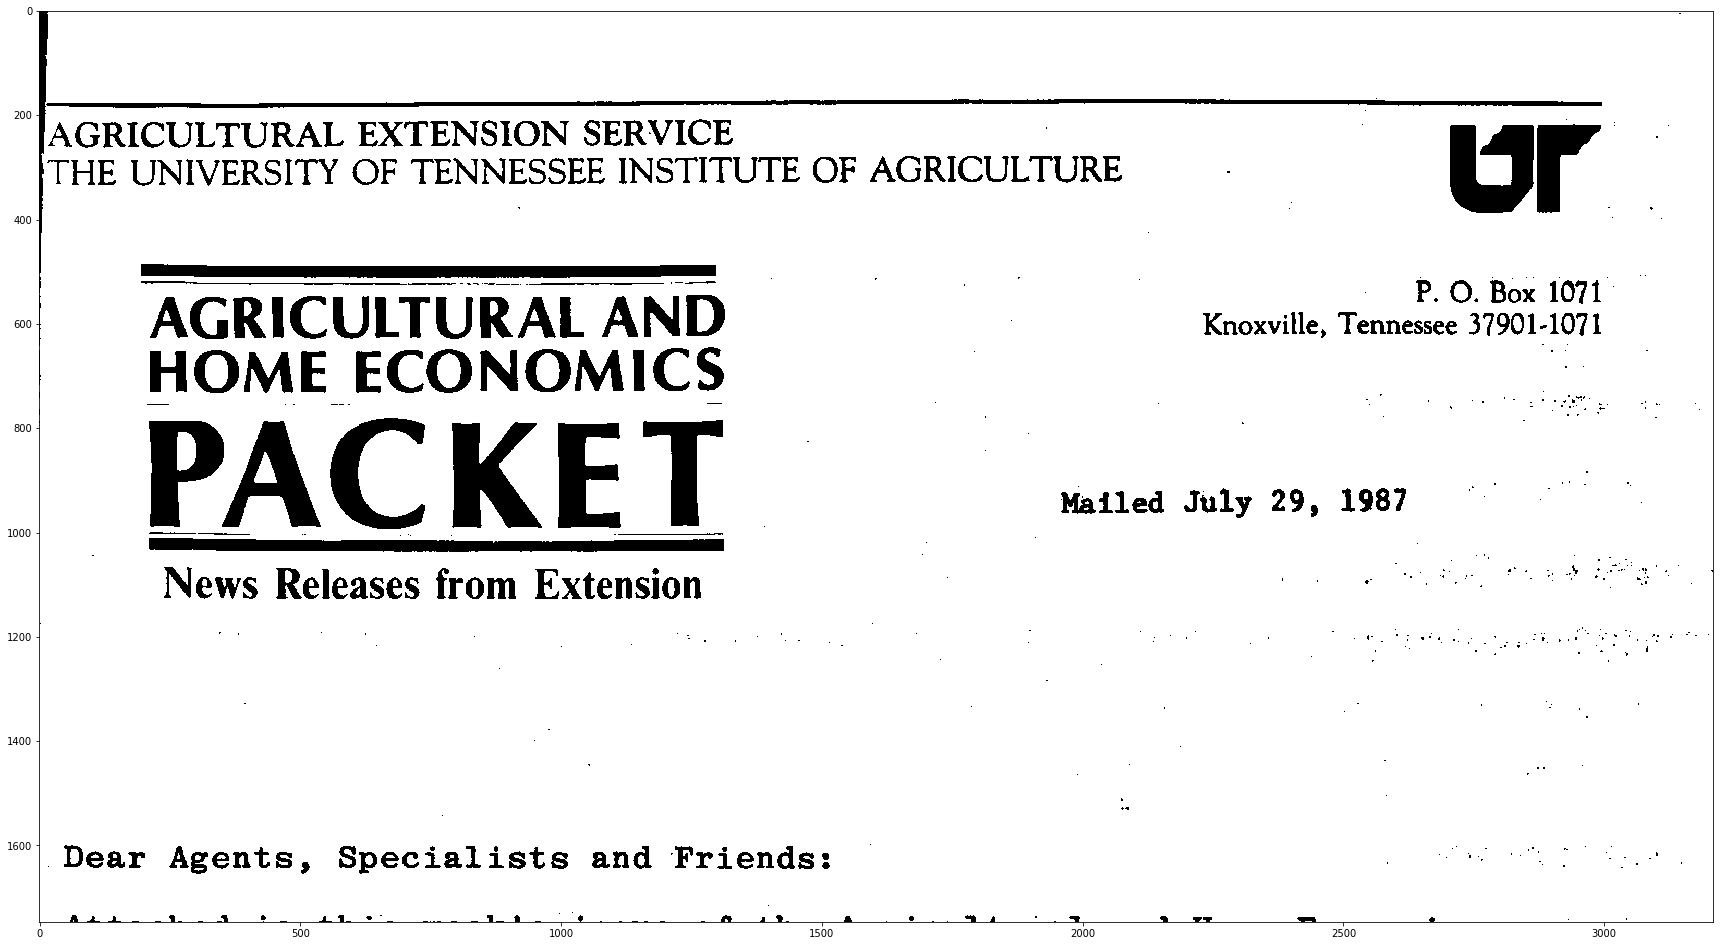



 
^^^^^^^^^^^^^^^^^^^^^^^^^

AGRICULTURAL EXTENSION SERVICE 7
AGRICULTURAL
EXTENSION
SERVICE
7
^^^^^^^^^^^^^^^^^^^^^^^^^

THE UNIVERSITY OF TENNESSEE INSTITUTE OF AGRICULTURE Or
THE
UNIVERSITY
OF
TENNESSEE
INSTITUTE
OF
AGRICULTURE
Or
^^^^^^^^^^^^^^^^^^^^^^^^^


 
^^^^^^^^^^^^^^^^^^^^^^^^^


 
^^^^^^^^^^^^^^^^^^^^^^^^^

 AGRICULTURAL AND soon Tan O58 0
~
AGRICULTURAL
AND
soon
Tan
O58
0
^^^^^^^^^^^^^^^^^^^^^^^^^

 HOME ECONOMICS 
_
HOME
ECONOMICS
°
^^^^^^^^^^^^^^^^^^^^^^^^^

PACKET estas
PACKET
estas.
^^^^^^^^^^^^^^^^^^^^^^^^^

News Releases from Extension
News
Releases
from
Extension
^^^^^^^^^^^^^^^^^^^^^^^^^


 
^^^^^^^^^^^^^^^^^^^^^^^^^

Dear Agents Specialists and Friends
Dear
Agents,
Specialists
and
Friends:
^^^^^^^^^^^^^^^^^^^^^^^^^

Rea  2 9  p eset ge  og a 
Rea.
.@
2.
9
|
,p
eset!
ge
“@
og
a
@
^^^^^^^^^^^^^^^^^^^^^^^^^


In [230]:
image_path = Path('data/images/0012_004266_003299_0001.tif')
issue = TnFarmNews(image_path)
issue.ocr()
quick_imshow(issue.binarized)
month = get_month(issue.line_and_word_boxes, debug=True)
for line in issue.line_and_word_boxes:
    line_condensed = [x for x in line.content if x.lower() in filter_chars]
    # join everything together into a single string
    string = ''
    text = string.join(line_condensed)
    
    print('')
    print(25*'=')
    print(text)
    for box in line.word_boxes:
        print(box.content)
    print(25*'^')

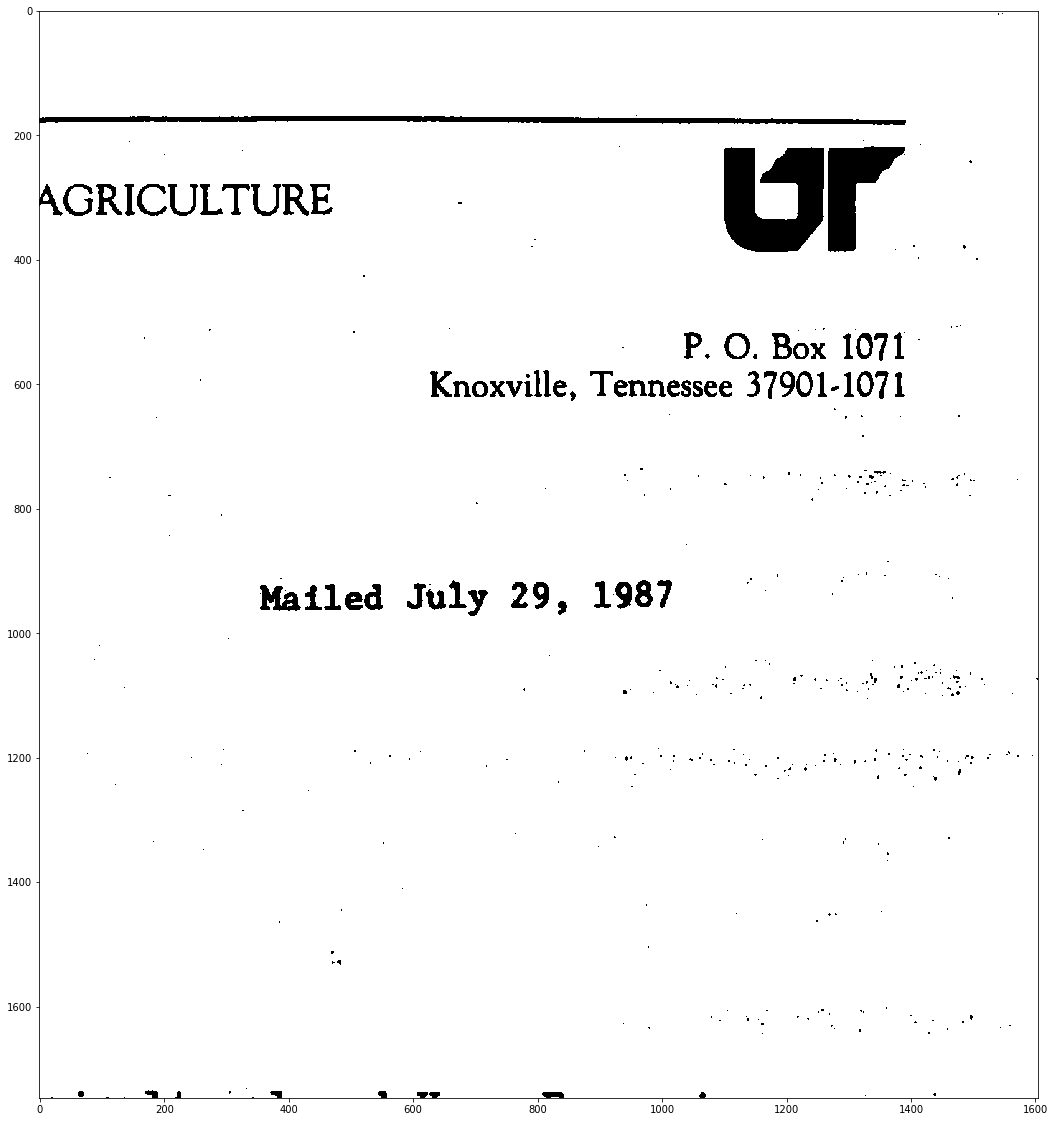

('July', 'july')


In [231]:
issue = TnFarmNews(image_path)
image = issue.preprocess_image()
image = image[0:issue.height_cropped, int(issue.width_cropped * 0.5):issue.width_cropped]
issue.ocr(image = image)
quick_imshow(issue.binarized)
month = get_month(issue.line_and_word_boxes)
print(month)

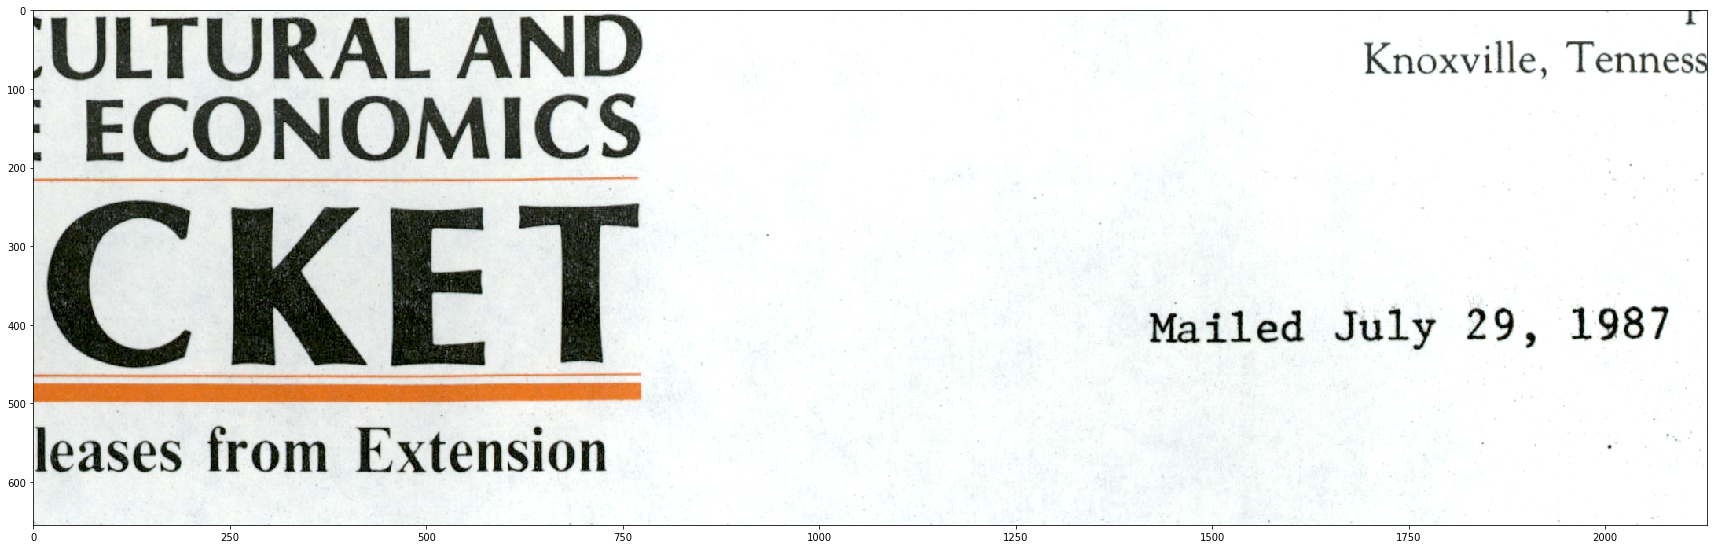


ULTU RAL AND Knoxville Tennes
‘ULTU
RAL
AND
Knoxville,
Tennes
^^^^^^^^^^^^^^^^^^^^^^^^^

 ECONOMICS 
-
ECONOMICS
|
^^^^^^^^^^^^^^^^^^^^^^^^^

C K E   Mailed July 29 1987
C
K
E
|
|
Mailed
July
29,
1987
^^^^^^^^^^^^^^^^^^^^^^^^^


 
^^^^^^^^^^^^^^^^^^^^^^^^^

a
a
^^^^^^^^^^^^^^^^^^^^^^^^^

leases from Extension
leases
from
Extension
^^^^^^^^^^^^^^^^^^^^^^^^^


In [232]:
issue = TnFarmNews(image_path)
image = issue.preprocess_image(crop_percentage=0.15, top_and_bottom_padding=550)
quick_imshow(image)
filter_chars = 'abcdefghijklmnopqrstuvwxyz1234567890 '
issue.ocr(image=image)
for line in issue.line_and_word_boxes:
    line_condensed = [x for x in line.content if x.lower() in filter_chars]
    # join everything together into a single string
    string = ''
    text = string.join(line_condensed)
    
    print('')
    print(25*'=')
    print(text)
    for box in line.word_boxes:
        print(box.content)
    print(25*'^')

In [233]:
fail_df = pd.DataFrame(rows_list_fail)
len(fail_df)

7

In [127]:
old_fail_df = fail_df
print(f'Length: {len(old_fail_df)}')
old_fail_df

Length: 56


,month_guess,path
0,None,data/images/0012_004266_000971_0001.tif
1,None,data/images/0012_004266_002257_0001.tif
2,None,data/images/0012_004266_000102_0001.tif
3,None,data/images/0012_004266_002316_0001.tif
4,None,data/images/0012_004266_000006_0001.tif
5,None,data/images/0012_004266_003104_0001.tif
6,None,data/images/0012_004266_000081_0001.tif
7,None,data/images/0012_004266_001305_0001.tif
8,None,data/images/0012_004266_002784_0001.tif
9,None,data/images/0012_004266_003048_0001.tif


In [151]:
# anything in the new fail list not in the old fail list?
test = fail_df.merge(old_fail_df, how='outer', indicator=True).query(
    '_merge == "left_only"').drop('_merge', 1)
test.reset_index(drop=True)

,month_guess,path


In [142]:
image_path = Path('data/images/0012_004266_000102_0001.tif')
issue = TnFarmNews(image_path)
issue.ocr()
filter_chars = 'abcdefghijklmnopqrstuvwxyz1234567890 '
for line in issue.line_and_word_boxes:
    line_condensed = [x for x in line.content if x.lower() in filter_chars]
    # join everything together into a single string
    string = ''
    text = string.join(line_condensed)
    
    print('')
    print(25*'=')
    print(text)
    for box in line.word_boxes:
        print(box.content)
    print(25*'^')


a
a
^^^^^^^^^^^^^^^^^^^^^^^^^

SPECIAL NEWS SERVICE
SPECIAL
NEWS
SERVICE
^^^^^^^^^^^^^^^^^^^^^^^^^

COOPERATIVE AGRICULTURAL EXTENSION WORK
COOPERATIVE
AGRICULTURAL
EXTENSION
WORK
^^^^^^^^^^^^^^^^^^^^^^^^^

UNITEO STATES DEPARTMENT OF AGRICULTURE
UNITEO
STATES
DEPARTMENT
OF
AGRICULTURE
^^^^^^^^^^^^^^^^^^^^^^^^^

COLLEGE OF AGRICULTURE UNIVERSITY OF TENNESSEE
COLLEGE
OF
AGRICULTURE,
UNIVERSITY
OF
TENNESSEE
^^^^^^^^^^^^^^^^^^^^^^^^^

TENNESSEE DEPARTMENT OF AGRICULTURE
TENNESSEE
DEPARTMENT
OF
AGRICULTURE
^^^^^^^^^^^^^^^^^^^^^^^^^

TENNESSEE BOARD OF EOUCATION ANO OTHER AGENCIES
TENNESSEE
BOARD
OF
EOUCATION.
ANO
OTHER
AGENCIES
^^^^^^^^^^^^^^^^^^^^^^^^^

DIVISION OF EXTENSION
DIVISION
OF
EXTENSION
^^^^^^^^^^^^^^^^^^^^^^^^^

CLL Atigg omnecton    Fo Yr Re le se
CLL
Atigg-——~
omnecton
,
.
.
Fo
Yr
Re
le
se
^^^^^^^^^^^^^^^^^^^^^^^^^

 TENNESSEE FARM NEWS Tune 1 1928
—_
‘TENNESSEE
FARM
NEWS
Tune
1,
1928
^^^^^^^^^^^^^^^^^^^^^^^^^

Prepared by the Division of Extension
Prepared
by
the
Division
o

In [145]:
month = get_month(issue.line_and_word_boxes)
print(month)

('Tune', 'june')


In [135]:
for i in range(len(test)):
    path = test.iloc[i]['path']
    issue = TnFarmNews(path)
    issue.ocr()
    filter_chars = 'abcdefghijklmnopqrstuvwxyz1234567890 '
    finding_month = True
    for line in issue.line_and_word_boxes:
        line_condensed = [x for x in line.content if x.lower() in filter_chars]
        # join everything together into a single string
        string = ''
        text = string.join(line_condensed)
        print(text)

a
SPECIAL NEWS SERVICE
COOPERATIVE AGRICULTURAL EXTENSION WORK
UNITEO STATES DEPARTMENT OF AGRICULTURE
COLLEGE OF AGRICULTURE UNIVERSITY OF TENNESSEE
TENNESSEE DEPARTMENT OF AGRICULTURE
TENNESSEE BOARD OF EOUCATION ANO OTHER AGENCIES
DIVISION OF EXTENSION
CLL Atigg omnecton    Fo Yr Re le se
 TENNESSEE FARM NEWS Tune 1 1928
Prepared by the Division of Extension
University of Tennessee
PERMANENT PROSPERITY
FOR THE FERMER

Permanent prosperity is not possible until the right relation between the
prices of the things the farmer sells and the things he buys is restored said
Frank 0 Lowden former governor of Illinois and a dandidate for president id
nn 7  ee ee   eo wm pe enamine 2 2 5 98 Oth reel kl tt
Agricultural Extension Service  O Box 1071
University of Tennessee Institute of Agriculture Knoxville Tennessee 379011071
AGRICULTURAL AND
HOME ECONOMICS
PACKET 
News Releases from Extension






Dear Editor
rLa T Teaterarcitey Af Tawnwnnaccnaa A weiniltevienl DCetancinn Qaewipna wnratnAoac

In [107]:
for i in range(len(fail_df)):
    path = fail_df.iloc[i]['path']
    issue = TnFarmNews(path)
    issue.ocr()
    filter_chars = 'abcdefghijklmnopqrstuvwxyz1234567890 '
    finding_month = True
    for line in issue.line_and_word_boxes:
        line_condensed = [x for x in line.content if x.lower() in filter_chars]
        # join everything together into a single string
        string = ''
        text = string.join(line_condensed)
        print(text)

COOPERATIVE AGRICULTURAL EXTENSION WORK
wees artiemcomene onracsortemecce TENNESSEE FARM AND HOME NEWS
AGRICULTURAL EXTENSION SERVICE A J SIMS EXTENSION EDITOR
CEA DIRECTOR
 KNOXVILLE TENNESSEE Aeprit 8  1940
THOUSANDS ENROLLING IN HOME
FOOD SUPPLY PROGRAM
Eee
County FARM AND Home AGENTS REPORT STATEWIDE
INTEREST IN MOVEMENT

THOUSANDS OF FARM FAMILIES IN EVERY SECTION OF THE STATE ARE
ENROLLING IN THE 1940 Home FooD SUPPLY PROGRAM ACCORDING TO REPORTS
RECEIVED FROM COUNTY FARM AND HOME AGENTS STATES C E BREHM
DIRECTOR OF THE UT AGRICULTURAL EXTENSION SERVICE
THE MOVEMENT WHICH 4S SPONSORED BY THE STATE DEPARTMENT OF AGRI
AGRICULTURAL
EXTENSION SERVICE
University of Tennessee
Knoxville
AMERICAN FARMER
SERVES CONSUMER
BEST IN WORLD






Tf you were a Russian working in Moscow today it would csst you
around 3 to buy a twopound chicken and you would have to work more
than five hours to earn that amount says Robert L Carter assistant
a
SPECIAL NEWS SERVICE
COOPERATIVE AGRICULTURAL EXTENSI


7 AGRICULTURAL EXTENSION SERVICE
THE UNIVERSITY OF TENNESSEE INSTITUTE OF AGRICULTURE Or


P O Box 1071
AGRICULTURAL AND Knoxville Tennessee ion
HOME ECONOMICS
PACKET rier seee 2s
News Releases from Extension


Dear Agents Specialists and Friends

A
Keep cold winds from blowing through the hen house  you cant
 draft hens into laying 

The farmer who follows proved practices can depend more upon
trial and less upon error


Dear Editor
PeM 44   2 ge 

WINTER IS TIME
TO FEED HAY
TO HORSES
Cold weather means hay
feeding time for horses says
Frederick Harper University of
Tennessee Extension horse
specialist
P O Box 1071
Knoxville Tennessee 37901


Quality which relates to the
nutrient content is the main
factor to consider in the pur
chase of horse hay The
characteristics of good analityv
AGRICULTU RAL
EXTENSION SERVICE
University of Tennessee
Knoxville
SEED SELECTION
IS BEST DEFENSE
FOR LEAF BLIGHT

A University of Tennessee agronomist reports that seed selection
will be the best defense

COOPERATIVE AGRICULTURAL EXTENSION WORK
sSier srtetcitune aac ores TENNESSEE FARM AND HOME NEWS
AGRICULTURAL EXTENSION SERVICE A J SIMS EXTENSION EDITOR
CEHM3 uti OIRECTOR 
KNOXVILLE TENNESSEE   FOR RELEASE
c
FOURH LHADERS 
BEING SELECTED
FO STATE Mail
 Program Filled With Good
 Citizenship Training
because of the influence for good citizenship the lennessee ourH Club

SPECIAL NEWS SERVICE
COOPERATIVE AGRICULTURAL EXTENSION WORK 
UNITED STATES DEPARTMENT OF AGRICULTURE
COLLEGE OF AGRICULTURE UNIVERSITY OF TENNESSEE
TENNESSEE DEPARTMENT OF AGRICULTURE
TENNESSEE BOARD OF EDUCATION AND OTHER AGENCIES
DIVISION OF EXTENSION
ChLAnigg omect on
KNOXVILLE TENNESSEE
TENNESSEE FARM NEWS
Prepared by the Division of Extension 
University of Tennessee
For Release 
FARMERS MUST CUT PRODUCTION
COSTS TO REALIZE PROFITS

The big problem with farmers throughout the country is that production cost
are too high say experts who are giving their time and thought to problems which
aA
 oe mo mi nank man anit  

AGRICULTURAL
EXTENSION SERVICE


University of Tennessee
Knoxville
ALFALFA RETURNING
NOW TO TENNESSEE

Alfalfa is still queen of the forage crops It can be used for
hay silage greenchop or pasture
It is a high yielding high quality crop which holds a good stand
for a number of years when recommended practices are followed states


In [ ]:
image_path = crop_df['image_path'][0]
image = cv2.imread(str(image_path))
x1, y1, x2, y2 = crop_df['title_crop'][0]
image_cropped = image[y1:y2, x1:x2]
plt.imshow(image), plt.show()
plt.imshow(image_cropped), plt.show()

In [ ]:
@interact
def show_images(file=page_1_paths_list):
    # load image
    issue = TnFarmNews(file)
    issue.ocr()
    # draw_month_box(issue.line_and_word_boxes, issue.image_cropped)
    # image = Image.open(file)
    # temp_image_path = Path('_temp_image.jpg')
    # image.save(temp_image_path)
    # display(ipyImage(temp_image_path))
    issue.guess_title(title_crops_dict, debug=True)
    print(issue.best_title)

In [ ]:
# this is my attempt to try and make a crop-value widget!

page_1_paths_dictionary = {path.name: path for path in page_1_paths_list}
initial_path = page_1_paths_list[0]
initial_images_key = initial_path.name
initial_image = cv2.imread(image)
initial_x2 =

# Create widgets
images = widgets.Dropdown(
    options=page_1_paths_dictionary, value=initial_path_key)
crop_x1 = widgets.IntRangeSlider(value=(100, , min=0, max=initial_image.shape[1])
crop_y1=widgets.IntSlider(value=0, min=0, max=initial_image.shape[0])
crop_x2=widgets.IntSlider()

# Updates the image options based on directory value
def update_crop(*args):
    crop_x1.max=os.listdir(directory.value)

# Tie the image options to directory value
directory.observe(update_crop, 'value')

# Show the images
def show_images(fdir, file):
    display(Image(f'{fdir}/{file}'))

_=interact(show_images, fdir=directory, file=images)
def crop_image(file=page_1_paths_list, x1=(0, Image.open(file).size[0])):
    # load image
    issue=TnFarmNews(file)
    issue.ocr()
    draw_month_box(issue.line_and_word_boxes, issue.image_cropped)
    # image = Image.open(file)
    # temp_image_path = Path('_temp_image.jpg')
    # image.save(temp_image_path)
    # display(ipyImage(temp_image_path))
    issue.guess_title(debug=True)
    print(issue.best_title)